# RNN with TensorFlow API

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### The Data

In [4]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1) 
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax- self.xmin - (steps*self.resolution) )
        
        # Create batch Time Series on t axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        
        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_ts
        
        else:
            
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 
        

In [5]:
ts_data = TimeSeriesData(250,0,10)

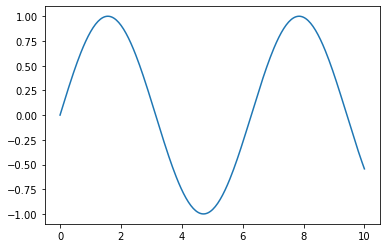

In [6]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [7]:
# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 30

In [8]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

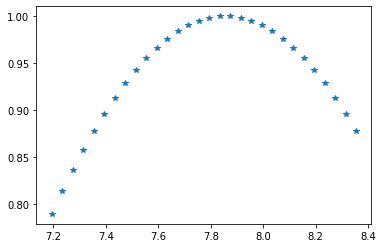

In [9]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

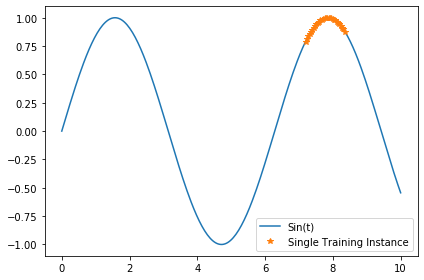

In [10]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

### A Training Instance and what to predict

We are trying to predict a time series shifted over by t+1

In [11]:
train_inst = np.linspace(5,5 + ts_data.resolution * (num_time_steps + 1), num_time_steps+1)

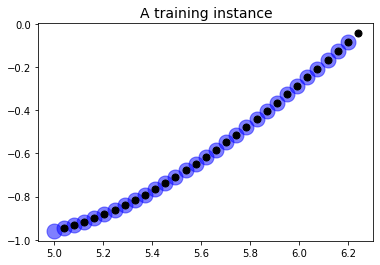

In [12]:
plt.title("A training instance", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), "bo", markersize=15,alpha=0.5 ,label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "ko", markersize=7, label="target")

___________

# Creating the Model

In [13]:
tf.reset_default_graph()

### Constants

In [14]:
# Just one feature, the time series
num_inputs = 1
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0001
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 2000
# Size of the batch of data
batch_size = 1

### Placeholders

In [13]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

____
____
### RNN Cell Layer

Play around with the various cells in this section, compare how they perform against each other.

In [14]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

In [15]:
# cell = tf.contrib.rnn.OutputProjectionWrapper(
#     tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
#     output_size=num_outputs)

In [16]:
# n_neurons = 100
# n_layers = 3

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
#           for layer in range(n_layers)])

In [17]:
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

In [18]:
# n_neurons = 100
# n_layers = 3

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
#           for layer in range(n_layers)])

_____
_____

### Dynamic RNN Cell

In [19]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss Function and Optimizer

In [20]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

#### Init Variables

In [21]:
init = tf.global_variables_initializer()

## Session

In [24]:
# ONLY FOR GPU USERS:
# https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

In [25]:
saver = tf.train.Saver()

In [26]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

0 	MSE: 0.779362
100 	MSE: 0.275911
200 	MSE: 0.0927696
300 	MSE: 0.013662
400 	MSE: 0.00182843
500 	MSE: 0.0175511
600 	MSE: 0.0148693
700 	MSE: 0.00287719
800 	MSE: 0.0032798
900 	MSE: 0.000910895
1000 	MSE: 0.0206152
1100 	MSE: 0.0103404
1200 	MSE: 0.00505896
1300 	MSE: 0.00421907
1400 	MSE: 0.0153266
1500 	MSE: 0.000523155
1600 	MSE: 0.00333744
1700 	MSE: 0.00301509
1800 	MSE: 0.000480476
1900 	MSE: 0.0106982


### Predicting a time series t+1

In [27]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_time_series_model")   

    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


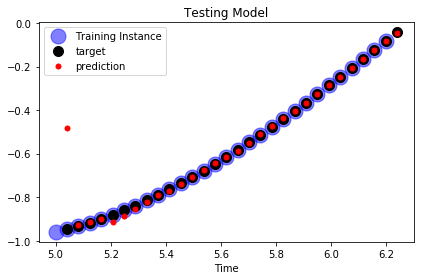

In [28]:
plt.title("Testing Model")

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")

# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

# Generating New Sequences
** Note: Can give wacky results sometimes, like exponential growth**

In [29]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED WITH ZEROS
    zero_seq_seed = [0. for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        zero_seq_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


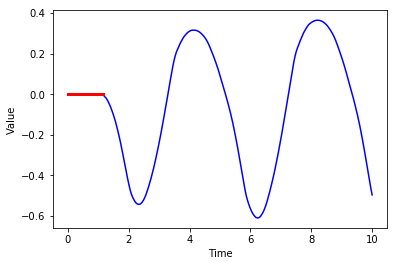

In [31]:
plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

In [33]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED WITH Training Instance
    training_instance = list(ts_data.y_true[:30])
    for iteration in range(len(training_instance) -num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


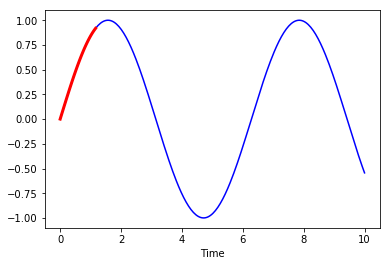

In [37]:
plt.plot(ts_data.x_data, ts_data.y_true, "b-")
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps], "r-", linewidth=3)
plt.xlabel("Time")

# Great Job!